<a href="https://colab.research.google.com/github/roshsoftco/phishing-website-detector/blob/1.3/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Desicion Tree based**
#**Phishing Website Detector**

---

Phishing websites are websites created to be very similar to the genuine websites of credible companies. Since these are equivalent to the legitimate ones, users are easily defrauded by them. Phishing attacks usually start with an email that asks users to update or validate their information by visiting the link given. When users click on such links they are redirected to phishing websites where they are asked to enter sensitive personal information such as usernames, passwords or credit card and bank account information. This helps attackers to carry out financial frauds eventually with the stolen information. With the number of phishing websites on the rise, it has become a serious problem even for experienced users to protect their valuable information from fraudulent persons.

The basic idea of creating a phishing detector is to train a model to identify a special set of characteristics of websites by the URL of that particular site.

**Libraries**

Importing necessary libraries into the project. The usage of the library is mentioned below as well.

In [1]:
import time # calculate performance
import pandas as pd # read csv files / calculate correlation
import matplotlib.pyplot as plt # draw graphs
import seaborn as sns # draw graphs
from sklearn import tree # DecisionTreeClassifier
import graphviz # draw tree

# Data Splitting and Preprocessing

---



**Dataset**

The dataset was obtained from the UCI Machine Learning Repository. It is a complete numerical dataset with over 11,000 instances.

Dataset contains 30 attributes. Each row has 31 values, 30 attributes and the class.

The entire dataset is separated into 3 categories as the **training set**, **validation set** and **testing set** as 75%, 20% and 5% (approx.) respectively and saved them into separate CSV files.

In [2]:
raw_dataset_url = "https://raw.githubusercontent.com/roshsoftco/phishing-website-detector/1.3/Dataset/raw_dataset.csv"
training_dataset_url = "https://raw.githubusercontent.com/roshsoftco/phishing-website-detector/1.3/Dataset/training_dataset.csv"
validation_dataset_url = "https://raw.githubusercontent.com/roshsoftco/phishing-website-detector/1.3/Dataset/validation_dataset.csv"
test_dataset_url = "https://raw.githubusercontent.com/roshsoftco/phishing-website-detector/1.3/Dataset/test_dateset.csv"

## Raw Data
raw_data = pd.read_csv(raw_dataset_url)
raw_data_cols = raw_data.columns.tolist()

attributes = [
              "having_IP_Address", "URL_Length", "Shortining_Service", "having_At_Symbol", "double_slash_redirecting", "Prefix_Suffix", "having_Sub_Domain", "SSLfinal_State", "Domain_registeration_length", "Favicon", "port", "HTTPS_token",
              "Request_URL", "URL_of_Anchor", "Links_in_tags", "SFH", "Submitting_to_email", "Abnormal_URL",
              "Redirect", "on_mouseover", "RightClick", "popUpWidnow", "Iframe",
              "age_of_domain", "DNSRecord", "web_traffic", "Page_Rank", "Google_Index", "Links_pointing_to_page", "Statistical_report"
]

rm = []  # attributes to remove

labels = ["Legitamate", "Phishing"]

**Calculating Correlation**

Pairwise correlation is calculated for all columns using Pandas `dataframe.corr()` function. Following is the heatmap demonstration of the correlation calculation.

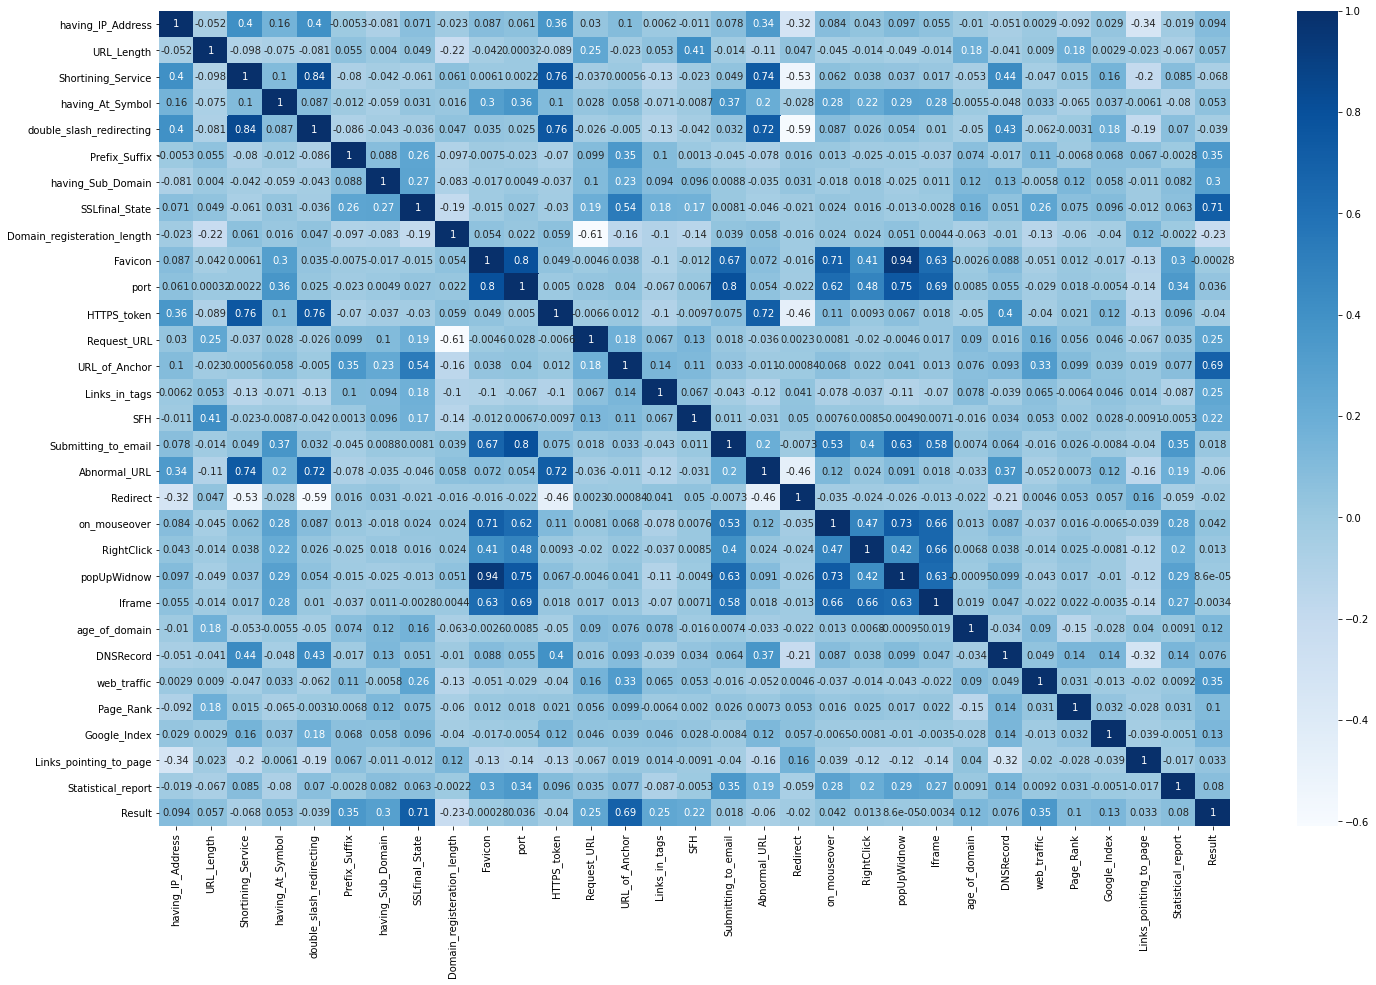

In [3]:
plt.figure(figsize=(24,15))
df = pd.DataFrame(raw_data.values, columns = raw_data_cols)
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

Attributes which has no correlation with the `Result` attribute are considered as irrelevant. And those attributes are removed from the datasets.

In [4]:
# Correlation with output variable
cor_target = abs(cor["Result"])

# Selecting least correlated features
irrelevant_features = cor_target[cor_target < 0.1]
irrelevant_features_keys = irrelevant_features.keys().tolist()

print("Irrelavant features (" + str(len(irrelevant_features_keys)) + "):", irrelevant_features_keys)

rm = []

for n in irrelevant_features_keys:
  rm.append(raw_data_cols.index(n))

for ele in sorted(rm, reverse = True):
  del attributes[ele] # remove element from row

Irrelavant features (18): ['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Favicon', 'port', 'HTTPS_token', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'DNSRecord', 'Links_pointing_to_page', 'Statistical_report']


**Spliting Class Labels**

The `labelSplitter` function will split the last value from each row, and return them as an array to be used as class values.

In [5]:
def labelSplitter(csv):
  
  data = []
  labels = []
  for rowArray in csv.values: # iterate through dataset row by row
    row = rowArray.tolist()
    labels.append(row[-1]) # extract last value as class [a1, a2, ..., class]
    
    for ele in sorted(rm, reverse = True):  
      del row[ele] # remove element from row
    
    data.append(row[:-1]); # rest of the data as attributes
  
  return [data, labels];

def timeDiff(start, end):
  return "{t:.3f} ms".format(t = (end-start))

# Loading Data
---
Since all the data preprocessing parts are ready, now it's time to load the datasets into separate variables.

All CSV files are uploaded to the repository, and `pandas` will read them directly using the URLs. Then it will assign them to variables after parsing through the `labelSplitter` function.

In [6]:
## Training Data
splitted = labelSplitter(pd.read_csv(training_dataset_url, header=None))
training_data = splitted[0]
training_data_labels = splitted[1]

## Validation Data
splitted = labelSplitter(pd.read_csv(validation_dataset_url, header=None))
validation_data = splitted[0]
validation_data_labels = splitted[1]

## Test Data
splitted = labelSplitter(pd.read_csv(test_dataset_url, header=None))
test_data = splitted[0]
test_data_labels = splitted[1]

splitted = None
total = len(training_data_labels) + len(validation_data_labels) + len(test_data_labels)

print("Training dataset size: ", len(training_data_labels))
print("Validation dataset size: ", len(validation_data_labels))
print("Testing dataset size: ", len(test_data_labels))

Training dataset size:  8444
Validation dataset size:  2111
Testing dataset size:  500


# Training and Validation

---

It is clear that this is a supervised learning task.

**Model Training**

SciKit-Learn’s DecisionTreeClassifier is being used as the model. The splitting criterion is set to `Entropy`.



In [7]:
clf = tree.DecisionTreeClassifier(criterion="entropy")

start = time.time()*1000
clf = clf.fit(training_data, training_data_labels) # train
end = time.time()*1000

print("Training completed in", timeDiff(start, end))

Training completed in 29.293 ms


**Performance Evaluation**

Let's measure the accuracy of the the trained model using the validation dataset.

In [8]:
print("Accuracy:", clf.score(validation_data, validation_data_labels))

Accuracy: 0.8924680246328754


# Visualising Model

---

One of the main advantages of a decision tree is that its rather easy to interpret and understand compared to other models. Since its a white box model, the model is can be easily visualised.

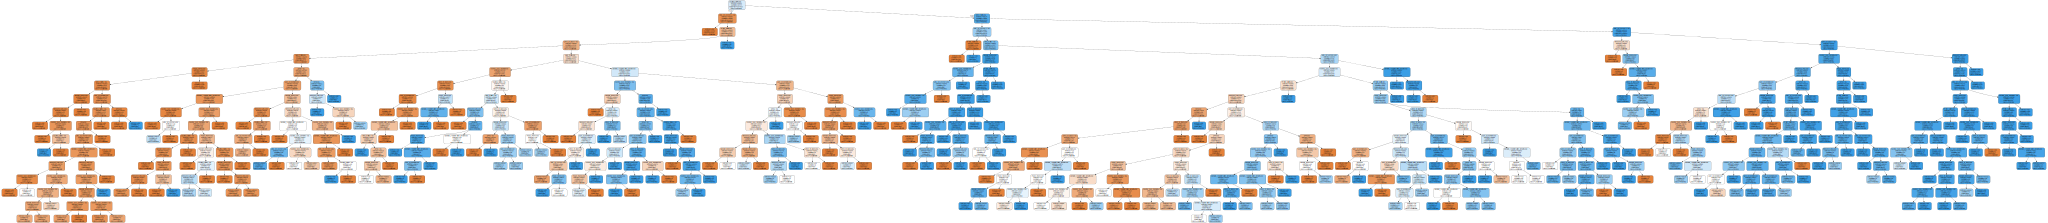

In [9]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=attributes,
                                class_names=labels,
                                filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Testing Model

---

Below is an interactive console app built for testing the trained model by giving testing data as inputs and making predictions in real-time. 

In [10]:
while(True):
  print()
  print("There are", len(test_data_labels), "instances which can be tested.")
  print()

  row = int(input("Enter row index (-1 exit): "))

  if(row < 0):
    break
  elif(row >= len(test_data_labels)):
    print("Error: Enter a number between 0 and", (len(test_data_labels)-1))
    continue

  i = []
  i.append(test_data[row])

  start = time.time()*1000
  prediction = clf.predict(i)[0]
  end = time.time()*1000

  testLbl = labels[0] if (test_data_labels[row] == -1) else labels[1]
  predLbl = labels[0] if (prediction == -1) else labels[1]

  print()
  print("Predicted answer:", prediction, predLbl)
  print("Correct answer:", test_data_labels[row], testLbl)
  print()

  state = "Incorrect!"
  if (prediction == test_data_labels[row]):
    state = "Correct!"
  print("Prediction is", state, "(", timeDiff(start, end) , ")")
  print("***")
  print()

print()
print("Application terminated.")


There are 500 instances which can be tested.

Enter row index (-1 exit): 150

Predicted answer: -1 Legitamate
Correct answer: -1 Legitamate

Prediction is Correct! ( 0.449 ms )
***


There are 500 instances which can be tested.

Enter row index (-1 exit): 3

Predicted answer: 1 Phishing
Correct answer: -1 Legitamate

Prediction is Incorrect! ( 0.876 ms )
***


There are 500 instances which can be tested.

Enter row index (-1 exit): 200

Predicted answer: -1 Legitamate
Correct answer: -1 Legitamate

Prediction is Correct! ( 0.708 ms )
***


There are 500 instances which can be tested.

Enter row index (-1 exit): -1

Application terminated.
